# *Importing Libraries:*

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.legacy import Adamax
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score

# *Preprocessing:*


In [3]:
path = 'Dataset/'
folders = os.listdir(path)
print(folders)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'D', 'Gh', 'H', 'J', 'L', 'M', 'N', 'P', 'PuV', 'PwD', 'Sad', 'Sin', 'T', 'Taxi', 'V', 'Y']


In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15)

train_generator = datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=64,
    shuffle=True,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=64,
    shuffle=False,
    class_mode='categorical',
    subset='validation')

Found 71281 images belonging to 28 classes.
Found 12563 images belonging to 28 classes.


### Show sample:

In [5]:
classes = list(train_generator.class_indices.keys())
img, lable = train_generator.next()
img.shape

(64, 128, 128, 3)

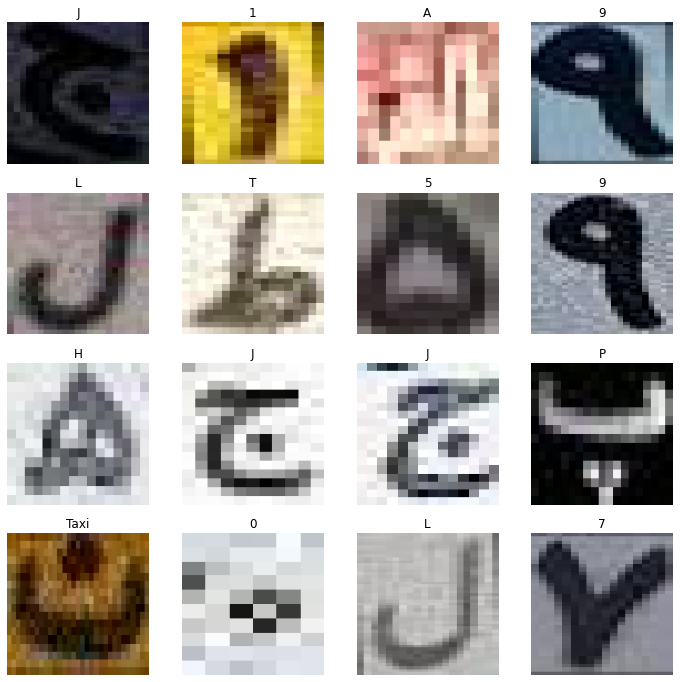

In [6]:
plt.figure(figsize= (12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    index = np.argmax(lable[i]) 
    class_name = classes[index]
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [7]:
def draw_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='darkblue')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='darkblue')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()
    
    print("Maximum Accuracy of Training set: {:.3f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc)*100, np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.3f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc)*100, np.min(val_loss))) 

# *Model Structure:*

In [7]:
# global parameters:
EPOCHS = 25
IMG_SHAPE = (128, 128, 3)
LR = 1e-3
OPTIMIZER = Adamax(LR)
LOSS = CategoricalCrossentropy()
METRICS = ['accuracy']

In [9]:
def lr_schedule(epoch):
    initial_learning_rate = LR
    decay = 0.9
    lr = initial_learning_rate * decay**(1.25 * epoch)
    return lr

In [10]:
lr_scheduler = LearningRateScheduler(lr_schedule)

# *Convolutional Neural Network:*
### *Using Transfer Learning...*


## VGG16:

In [10]:
base_model = tf.keras.applications.VGG16(include_top=False, 
                                         weights='imagenet', 
                                         input_shape=IMG_SHAPE)

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [12]:
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [13]:
model_cnn = Sequential([
    base_model,
    Flatten(),
    Dense(256, 'relu'),
    BatchNormalization(),
    Dense(64, 'relu'),
    BatchNormalization(),
    Dense(len(classes), "softmax")
])

model_cnn.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [14]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [15]:
len(model_cnn.trainable_variables)

12

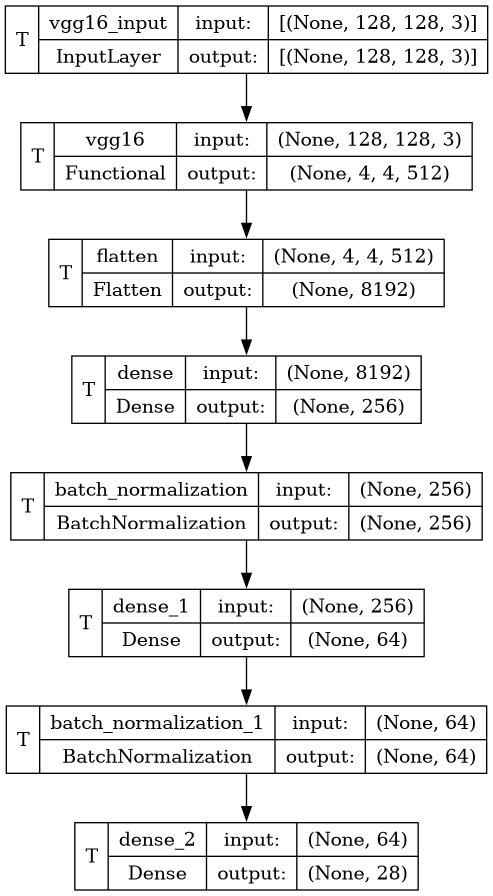

In [16]:
plot_model(model_cnn, show_shapes = True, show_trainable = True)

In [17]:
hist_cnn = model_cnn.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS, callbacks=[lr_scheduler])

Epoch 1/25
1114/1114 [==============================] - 439s 389ms/step - loss: 0.1536 - accuracy: 0.9706 - val_loss: 0.1939 - val_accuracy: 0.9435 - lr: 0.0010
Epoch 2/25
1114/1114 [==============================] - 118s 106ms/step - loss: 0.0290 - accuracy: 0.9939 - val_loss: 0.1097 - val_accuracy: 0.9703 - lr: 8.7660e-04
Epoch 3/25
1114/1114 [==============================] - 118s 105ms/step - loss: 0.0146 - accuracy: 0.9970 - val_loss: 0.0958 - val_accuracy: 0.9717 - lr: 7.6843e-04
Epoch 4/25
1114/1114 [==============================] - 117s 105ms/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 0.1521 - val_accuracy: 0.9573 - lr: 6.7361e-04
Epoch 5/25
1114/1114 [==============================] - 118s 105ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.0787 - val_accuracy: 0.9789 - lr: 5.9049e-04
Epoch 6/25
1114/1114 [==============================] - 118s 106ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0819 - val_accuracy: 0.9791 - lr: 5.1763e-04
Epoch 7/25
111

Maximum Accuracy of Training set: 100.000
Minimum Loss of Trainig set: 0.00001290

Maximum Accuracy of Validation set: 98.687
Minimum Loss of Validation set: 0.05834417



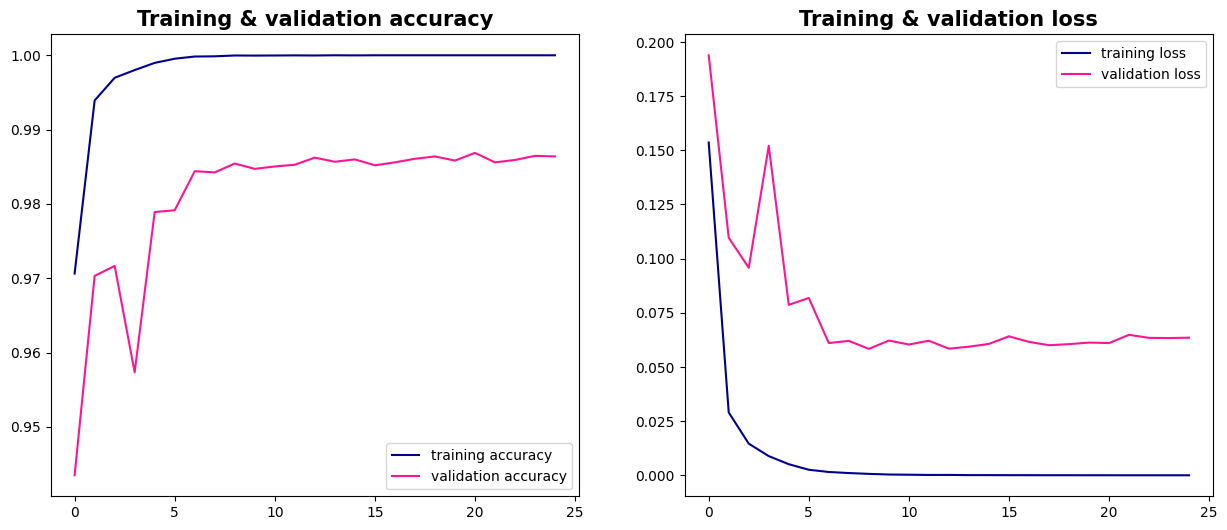

In [18]:
draw_plot(hist_cnn)

## *Evaluation:*

In [19]:
loss, accuracy = model_cnn.evaluate(validation_generator)
print('Test accuracy :', accuracy * 100)

197/197 [==============================] - 17s 85ms/step - loss: 0.0635 - accuracy: 0.9864
Test accuracy : 98.6388623714447


In [20]:
# Generate predictions
predictions = model_cnn.predict(validation_generator)

197/197 [==============================] - 16s 80ms/step


In [22]:
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes

class_labels = list(validation_generator.class_indices.keys())

## *Calculate classification report:*

In [46]:
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

print(f'Old Precision: 0.974804')
print(f'New Precision: {precision:.6f}')
print(f"The difference is  {(precision - 0.974804)*100 :.3f}%  better\n")

print(f'Old Recall: 0.981003')
print(f'New Recall: {recall:.6f}')
print(f"The difference is  {(recall - 0.981003)*100 :.3f}%  better")

Old Precision: 0.974804
New Precision: 0.986430
The difference is  1.163%  better

Old Recall: 0.981003
New Recall: 0.986389
The difference is  0.539%  better


In [36]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       375
           1       0.96      0.99      0.98       524
           2       0.93      0.92      0.93       589
           3       0.91      0.92      0.92       411
           4       0.99      0.96      0.98       866
           5       1.00      0.99      0.99       541
           6       0.98      0.99      0.99       862
           7       0.98      0.98      0.98       560
           8       1.00      0.99      0.99       537
           9       0.99      0.98      0.98       529
           A       1.00      1.00      1.00       377
           B       1.00      1.00      1.00       376
           D       1.00      1.00      1.00       375
          Gh       0.99      1.00      1.00       372
           H       0.99      1.00      1.00       383
           J       1.00      1.00      1.00       375
           L       0.99      0.99      0.99       375
           M       0.99    

## *Compute confusion matrix:*

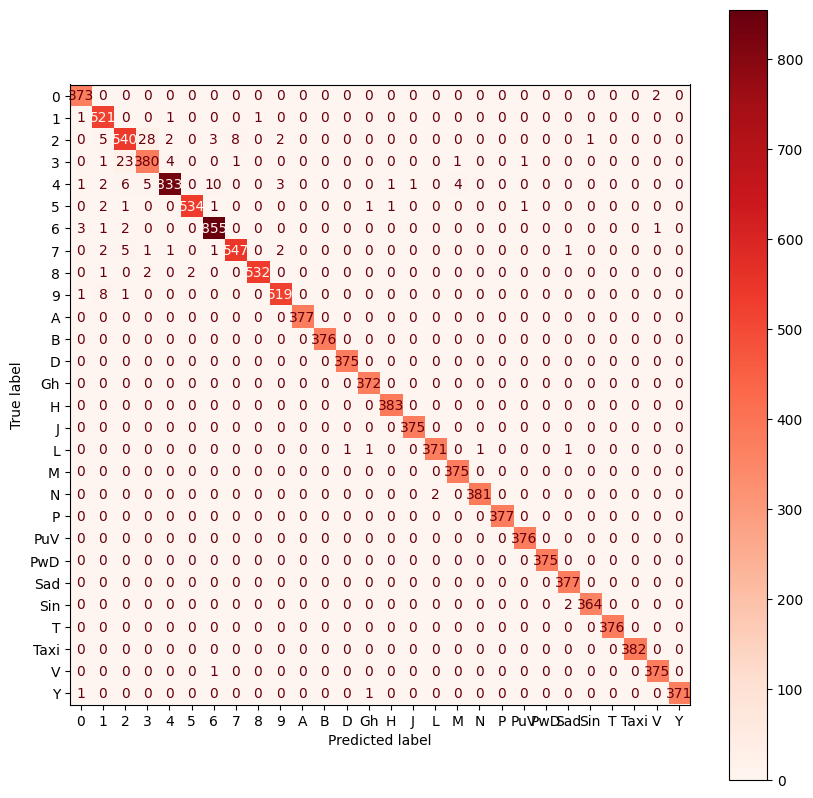

In [54]:
cm = confusion_matrix(true_classes, predicted_classes)

class_labels = list(validation_generator.class_indices.keys())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(10, 10))
display.plot(ax=ax, values_format='.4g', cmap='Reds')
plt.show()

## *Save Model:*

In [26]:
model_cnn.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
